<a href="https://colab.research.google.com/github/burakayy7/ewstools-flu-dataset/blob/main/EWS_Flu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ewstools
!pip install -U kaleido
import pandas as pd
from datetime import datetime
import ewstools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.0 MB/s eta 0:00:00


In [ ]:
#this cell simply fetches the flu data and converts to types that are necessary for the ewstools library
data = pd.read_csv('https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

import matplotlib.pyplot as plt

#data.query('location_name == "US"')

new_data = data.query('location == "US"')
new_data.plot(x='date', y='value')
new_data.plot(x='date', y='weekly_rate')

ews_data = new_data[['date', 'weekly_rate']]
print(type(ews_data['weekly_rate'].iloc[1]))
print(len(ews_data))
#ews_data = ews_data.to_numpy()
#ews_data = ews_data.reshape(-1)
#ews_data = pd.to_datetime(ews_data['date'])
#ews_data.set_index('date', inplace=True)
ews_data = ews_data.set_index('date')['weekly_rate']
ews_data = ews_data.reset_index(drop=True)
#ews_data = ews_data.stack()
#ews_data
#print(len(ews_data))
#type(ews_data['weekly_rate'])
#data.loc[2000]

In [ ]:
#here we create a TimeSeries object from the flu data and then create a detrended version
ts = ewstools.TimeSeries(data=ews_data, transition=5000)

ts.detrend(method='Lowess', span=0.2)
#ts.state.plot()
ts.state.iloc[1]

state        1.492173
smoothing    1.562783
residuals   -0.070609
Name: 1, dtype: float64

{'variance': 0.10237904303662121,
 'std': 0.10237904303662121,
 'ac3': 0.26757551456829726,
 'ac1': 0.26704089815557336}

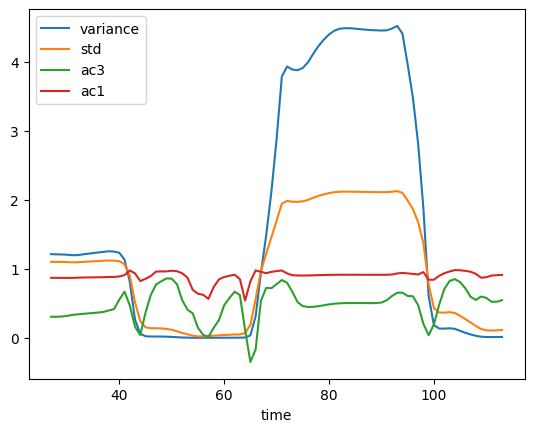

In [ ]:
#in this cell we calculate various statistical metrics accross the data using a rolling window that spans 25% of the data length

rw = .25

ts.compute_var(rolling_window=rw)
#ts.compute_cv(rolling_window=rw)
ts.compute_std(rolling_window=rw)
ts.compute_auto(rolling_window=rw, lag=1)
ts.compute_auto(rolling_window=rw, lag=3)
#ts.compute_skew(rolling_window=rw)

ts.ews.dropna().plot()

ts.compute_ktau()
ts.ktau

In [ ]:
from IPython.display import Image
import kaleido
fig = ts.make_plotly(kendall_tau=True)
fig.show()
#Image(fig.to_image()) # use the command fig.show() if running a Jupyter notebook to view the interactive version

In [ ]:
#clone the repo where the DL classifiers are

!git clone https://github.com/ThomasMBury/ewstools


Cloning into 'ewstools'...
remote: Enumerating objects: 5217, done.
remote: Counting objects: 100% (1117/1117), done.
remote: Compressing objects: 100% (454/454), done.
remote: Total 5217 (delta 665), reused 1068 (delta 637), pack-reused 4100
Receiving objects: 100% (5217/5217), 25.02 MiB | 18.98 MiB/s, done.
Resolving deltas: 100% (2381/2381), done.


1/1 [==============================] - 1s 953ms/step


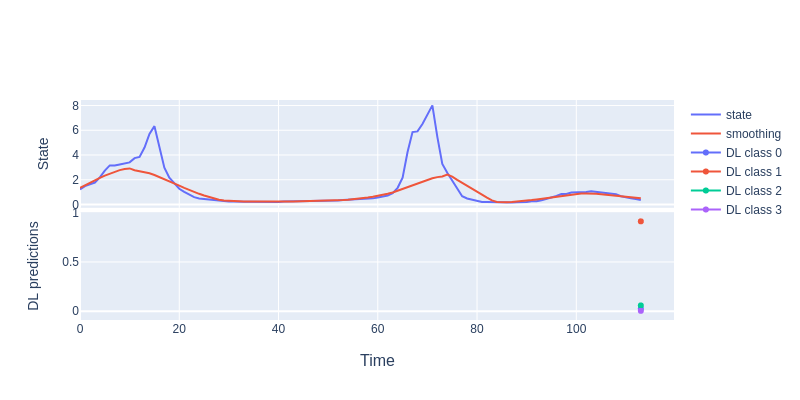

In [ ]:
#in this cell we define a classifier from the repo above and apply the classification for prediction

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # comment out to see TensorFlow warnings
from tensorflow.keras.models import load_model

classifier_path = '/content/ewstools/saved_classifiers/bury_pnas_21/len500/best_model_1_1_len500.pkl'
classifier = load_model(classifier_path)

ts.apply_classifier(classifier, tmin=0, tmax=114)

ts.dl_preds

fig = ts.make_plotly()
Image(fig.to_image()) # use fig.show() to show interactive figure

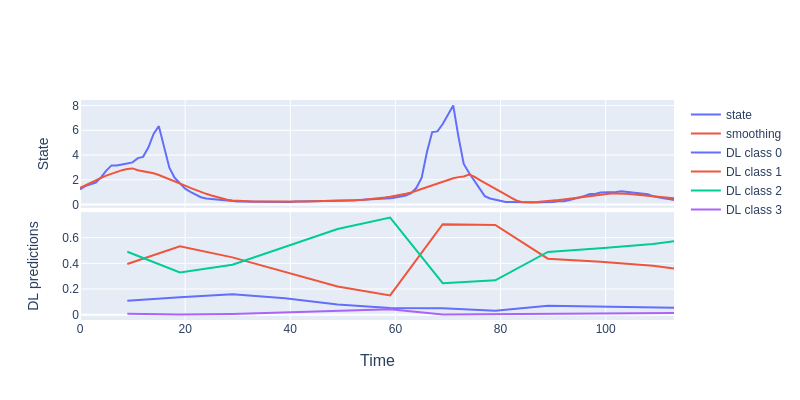

In [ ]:
classifier_path = '/content/ewstools/saved_classifiers/bury_pnas_21/len500/best_model_10_2_len500.pkl'
classifier = load_model(classifier_path)
ts.clear_dl_preds() # Clear previous data in dl_preds
ts.apply_classifier_inc(classifier, inc=10, verbose=0) # Set verbose=1 to see progress
ts.dl_preds.head()

fig = ts.make_plotly()
Image(fig.to_image()) # use fig.show() to show interactive figure

In [ ]:
#here we attempt to take the average from the predictions accross 6 different DL predictions

import os
# Clear previous DL predictions
ts.clear_dl_preds()
# Get classifier names
root_path = '/content/ewstools/saved_classifiers/bury_pnas_21/len500/'
classifier_names = [name[:-4] for name in os.listdir(root_path) if name[-4:]=='.pkl']

# This cell takes ~ 1 minute to run on Macbook Air (M1, 2020)
for classifier_name in classifier_names[:6]:
    # Import classifier
    classifier = load_model(root_path + classifier_name + '.pkl')
    # Get DL predictions - note we can provide a classifier name for reference
    ts.apply_classifier_inc(classifier, inc=10, verbose=0, name=classifier_name)
    print('Predictions complete for classifier {}'.format(classifier_name))

Predictions complete for classifier best_model_5_1_len500
Predictions complete for classifier best_model_6_2_len500
Predictions complete for classifier best_model_8_1_len500
Predictions complete for classifier best_model_10_2_len500
Predictions complete for classifier best_model_8_2_len500
Predictions complete for classifier best_model_1_2_len500


In [ ]:
ts.dl_preds['classifier'].unique()

array(['best_model_5_1_len500', 'best_model_6_2_len500',
       'best_model_8_1_len500', 'best_model_10_2_len500',
       'best_model_8_2_len500', 'best_model_1_2_len500'], dtype=object)

In [ ]:
ts.make_plotly()

In [ ]:
ts.make_plotly(ens_avg=True)

TypeError: Could not convert best_model_5_1_len500best_model_6_2_len500best_model_8_1_len500best_model_10_2_len500best_model_8_2_len500best_model_1_2_len500 to numeric